In [3]:
# Project 1: Fall 2025
# Member/s: Sergey Dutt
# Coder: Sergey Dutt

import sympy as sp 
import pandas as pd

In [4]:
# function and loop to create derivatives 
t, y = sp.symbols('t y')

def d(f):
    d_list = {1: f}
    max_order = 8

    for i in range(2, max_order + 1):
        d_prev = d_list[i - 1]
        d_current = sp.diff(d_prev, t) + sp.diff(d_prev, y) * f
        d_list[i] = sp.simplify(d_current)
        
    return d_list

generic = d(f = sp.Function('f')(t, y))
print("Testing: y'' = ", generic[2])

Testing: y'' =  f(t, y)*Derivative(f(t, y), y) + Derivative(f(t, y), t)


In [5]:
# Task 3: Replicate the Results from Tasks 1 and 2
task_3a = d(f = t**2 + y)
print("The Second Derivative for (a) = ", task_3a[2])
print("The Third Derivative for (a) = ", task_3a[3])

task_3b = d(f = t + y**2)
print("The Second Derivative for (b) = ", task_3b[2])
print("The Third Derivative for (b) = ", task_3b[3])

The Second Derivative for (a) =  t**2 + 2*t + y
The Third Derivative for (a) =  t**2 + 2*t + y + 2


The Second Derivative for (b) =  2*y*(t + y**2) + 1
The Third Derivative for (b) =  2*y + 2*(t + y**2)*(t + 3*y**2)


In [6]:
# function and loop to create a taylor-series approximation 
t_0, y_0, h = sp.symbols('t_0 y_0 h')

def taylor(t_0, y_0, h, order, kind):
    
    series = y_0 # first term in taylor series is y
    
    for n in range (1, order + 1): 
        
        # taylor series = previously computed series + h^(n) / n! * y^(n) (t)
        series = series + ((h**n) / (sp.factorial(n))) * kind[n].subs({t: t_0, y: y_0})
        
        symbolic = isinstance(t_0, sp.Basic) or isinstance(y_0, sp.Basic)

    if symbolic:
        return sp.simplify(series)
    else:
        return float(series) 

In [7]:
# Task 4: Generate 4th, 5th, 6th, and 8th order taylor approximation polynomials for y(t+h)
# Takes ~ 20 sec to run because it uses a generic f(t, y)
generic = d(f = sp.Function('f')(t, y))
T2 = taylor(t_0, y_0, h, order = 2, kind = generic) # added 2nd order to display 
                                                    # higher order taylor polynomials are not easy to read
T4 = taylor(t_0, y_0, h, order = 4, kind = generic)
T5 = taylor(t_0, y_0, h, order = 5, kind = generic)
T6 = taylor(t_0, y_0, h, order = 6, kind = generic)
T8 = taylor(t_0, y_0, h, order = 8, kind = generic)

print("2nd Order Taylor approximation polynomial for y(t+h) = ", T2)

2nd Order Taylor approximation polynomial for y(t+h) =  h**2*(f(t_0, y_0)*Derivative(f(t_0, y_0), y_0) + Derivative(f(t_0, y_0), t_0))/2 + h*f(t_0, y_0) + y_0


In [8]:
# Rk4 function
def rk4(f, t_0, y_0, h):
    
    f = sp.lambdify((t, y), f, modules=['numpy'])
    
    k1 = f(t_0, y_0)
    k2 = f(t_0 + h/2, y_0 + (h/2 * k1))
    k3 = f(t_0 + h/2, y_0 + (h/2 * k2))
    k4 = f(t_0 + h, y_0 + (h * k3))
    
    return y_0 + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

In [9]:
# Creating a table function 

def table(f, t_0, y_0, h, t_end, numerical_methods, true_solution):
    steps = int((t_end - t_0) / h)
    t_values = [t_0]
    results = {method: [y_0] for method in numerical_methods}

    f_derivatives = d(f)

    for i in range(steps):
        t_current = t_values[-1]
        for method in numerical_methods:
            if method == 'RK4':
                y_next = rk4(f, t_current, results[method][-1], h)
            elif method.startswith('T'):
                order = int(method[1:])
                y_next = taylor(t_current, results[method][-1], h, order, f_derivatives)
            else:
                raise ValueError(f"Unknown method: {method}")
            results[method].append(y_next)
        t_values.append(t_current + h)

    # Build dataframe
    data = {'t': t_values}
    for method in numerical_methods:
        data[f'{method}_y'] = results[method]
        data[f'{method}_error'] = [
            abs(float(true_solution(t_val)) - y_val)
            for t_val, y_val in zip(t_values, results[method])
        ]

    return pd.DataFrame(data)

In [10]:
# true solution solver
def ode_solver(f, t_0, y_0):
    y_symbolic = sp.Function('y')(t)
    ode = sp.Eq(y_symbolic.diff(t), f.subs(y, y_symbolic)) #lhs = dy/dt, rhs = f(t,y)
    y_true_solution = sp.dsolve(ode, y_symbolic, ics = {y_symbolic.subs(t, t_0): y_0})
    y_true_function = sp.lambdify(t, y_true_solution.rhs, modules=['numpy'])
    return(y_true_function)

In [11]:
# Task 5
# dy/dt = t^4, y(0) = 1, step size h = 0.1
# find y(1) using RK4, T4, and T5, then calculate the total error at each node

task_5 = d(f = t**4)

RK4 = rk4(f = t**4, t_0 = 0 , y_0 = 1, h = 0.1)
T4 = taylor(t_0 = 0, y_0 = 1, h = 0.1, order = 4, kind = task_5)
T5 = taylor(t_0 = 0, y_0 = 1, h = 0.1, order = 5, kind = task_5)

methods = ['RK4', 'T4', 'T5']

y_true = ode_solver(f = t**4, t_0 = 0, y_0 = 1)

task_5_solution = table(f = t**4, 
                        t_0 = 0, y_0 = 1, h = 0.1, t_end = 1, 
                       numerical_methods = methods, 
                       true_solution = y_true)

print(task_5_solution)

      t     RK4_y     RK4_error     T4_y  T4_error      T5_y      T5_error
0   0.0  1.000000  0.000000e+00  1.00000  0.000000  1.000000  0.000000e+00
1   0.1  1.000002  8.333333e-08  1.00000  0.000002  1.000002  0.000000e+00
2   0.2  1.000064  1.666667e-07  1.00006  0.000004  1.000064  0.000000e+00
3   0.3  1.000486  2.500000e-07  1.00048  0.000006  1.000486  0.000000e+00
4   0.4  1.002048  3.333333e-07  1.00204  0.000008  1.002048  0.000000e+00
5   0.5  1.006250  4.166667e-07  1.00624  0.000010  1.006250  0.000000e+00
6   0.6  1.015553  5.000000e-07  1.01554  0.000012  1.015552  2.220446e-16
7   0.7  1.033615  5.833333e-07  1.03360  0.000014  1.033614  4.440892e-16
8   0.8  1.065537  6.666667e-07  1.06552  0.000016  1.065536  6.661338e-16
9   0.9  1.118099  7.500000e-07  1.11808  0.000018  1.118098  6.661338e-16
10  1.0  1.200001  8.333333e-07  1.19998  0.000020  1.200000  6.661338e-16


In [12]:
# Task 6
# dy/dt = -ty, y(1) = 1, step size h = 0.1
# find y(2) using RK4, and T4, then calculate the total error at each node

task_6 = d(f = -1*t*y)

RK4 = rk4(f = -1*t*y, t_0 = 1 , y_0 = 1, h = 0.1)
T4 = taylor(t_0 = 1, y_0 = 1, h = 0.1, order = 4, kind = task_6)

methods = ['RK4', 'T4']

y_true = ode_solver(f = -1*t*y, t_0 = 1, y_0 = 1)

task_6_solution = table(f = -1*t*y, 
                        t_0 = 1, y_0 = 1, h = 0.1, t_end = 2, 
                       numerical_methods = methods,
                       true_solution = y_true)

print(task_6_solution)

      t     RK4_y     RK4_error      T4_y      T4_error
0   1.0  1.000000  0.000000e+00  1.000000  0.000000e+00
1   1.1  0.900325  9.303873e-08  0.900325  4.774137e-07
2   1.2  0.802519  2.185893e-07  0.802520  7.615306e-07
3   1.3  0.708221  3.797566e-07  0.708221  8.625789e-07
4   1.4  0.618784  5.771532e-07  0.618784  8.046847e-07
5   1.5  0.535262  8.083934e-07  0.535262  6.219538e-07
6   1.6  0.458407  1.067905e-06  0.458406  3.540158e-07
7   1.7  0.388681  1.347105e-06  0.388680  4.158625e-08
8   1.8  0.326281  1.634932e-06  0.326280  2.774664e-07
9   1.9  0.271174  1.918678e-06  0.271172  5.711911e-07
10  2.0  0.223132  2.185018e-06  0.223129  8.155519e-07


In [13]:
# Task 7
# dy/dt = sin(5pi t) + cos(5pi t) + y(t), y(0) = 1, step size h = 0.2, solve for y(2)

f_ = sp.sin(5 * sp.pi * t) + sp.cos(5 * sp.pi * t) + y
t0_ = 0
y0_ = 1
h_ = 0.2

task_7 = d(f = f_)

RK4 = rk4(f = f_, t_0 = t0_ , y_0 = y0_, h = h_)
T4 = taylor(t_0 = t0_, y_0 = y0_, h = h_, order = 4, kind = task_7)
T6 = taylor(t_0 = t0_, y_0 = y0_, h = h_, order = 6, kind = task_7)
T8 = taylor(t_0 = t0_, y_0 = y0_, h = h_, order = 8, kind = task_7)

methods = ['RK4', 'T4', 'T6', 'T8']

y_true = ode_solver(f = f_, t_0 = t0_, y_0 = y0_)

task_7_solution = table(f = f_, 
                        t_0 = t0_, y_0 = y0_, h = h_, t_end = 2, 
                       numerical_methods = methods,
                       true_solution = y_true)
print("y(2) = ", y_true(2))
print(task_7_solution)

y(2) =  7.819943590689912
      t     RK4_y     RK4_error      T4_y      T4_error      T6_y  \
0   0.0  1.000000  1.110223e-16  1.000000  1.110223e-16  1.000000   
1   0.2  1.376133  4.915853e-03  1.175129  1.960889e-01  1.416583   
2   0.4  1.526076  1.081830e-03  1.481573  4.342061e-02  1.535038   
3   0.6  2.018682  6.235752e-03  1.763322  2.491242e-01  2.070080   
4   0.8  2.310885  2.692185e-03  2.199993  1.081998e-01  2.333221   
5   1.0  2.977249  8.200480e-03  2.640801  3.282477e-01  3.044983   
6   1.2  3.481678  5.089266e-03  3.271745  2.048438e-01  3.523971   
7   1.4  4.407255  1.112505e-02  3.949838  4.462920e-01  4.499368   
8   1.6  5.228288  8.657402e-03  4.870604  3.490270e-01  5.300360   
9   1.8  6.540565  1.547837e-02  5.902684  6.224021e-01  6.669055   
10  2.0  7.833912  1.396867e-02  7.255810  5.641338e-01  7.950421   

        T6_error      T8_y      T8_error  
0   1.110223e-16  1.000000  1.110223e-16  
1   4.536566e-02  1.365135  6.082834e-03  
2   1.004408e-02

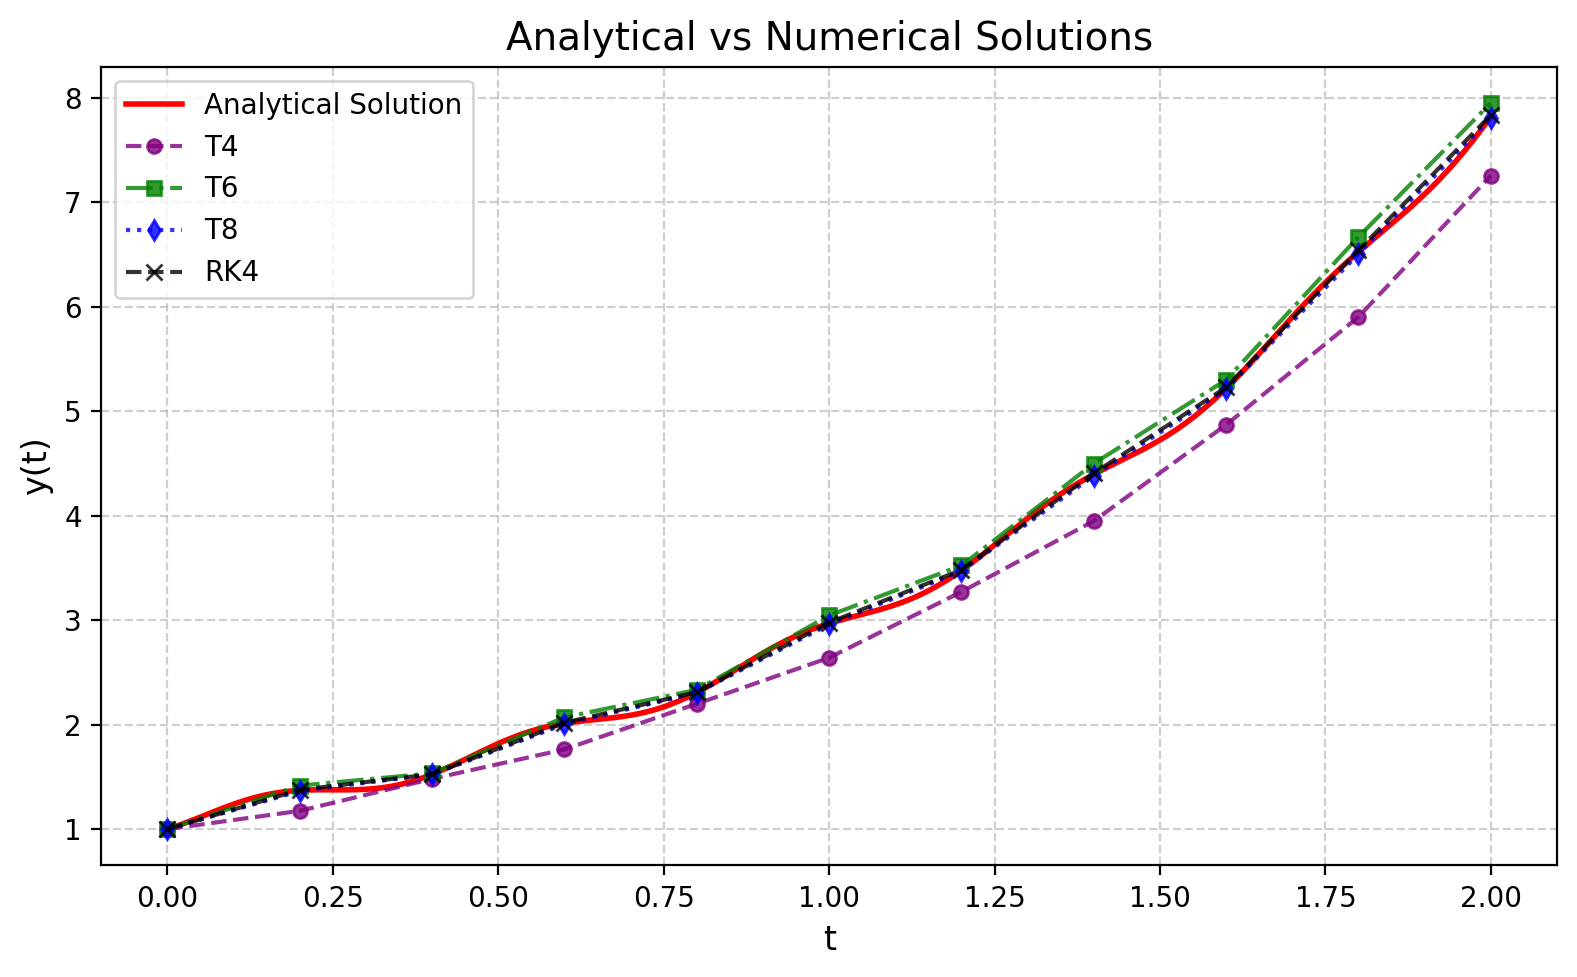

In [14]:
# Task 7 Continued
# plot the analytical solution (in red) and all numerical solutions (T4, T6, T8) on one plot

import numpy as np
import matplotlib.pyplot as plt

# smooth analytical solution curve
t_vals = np.linspace(0, 2, 300)
y_vals = y_true(t_vals)

# plot analytical solution
plt.figure(figsize=(8, 5))
plt.plot(t_vals, y_vals, 'r-', label='Analytical Solution', linewidth=2)

# overlay numerical methods from table
plt.plot(task_7_solution['t'], task_7_solution['T4_y'], 'o--', color='purple', label='T4', alpha=0.8, markersize=5)
plt.plot(task_7_solution['t'], task_7_solution['T6_y'], 's-.', color='green', label='T6', alpha=0.8, markersize=5)
plt.plot(task_7_solution['t'], task_7_solution['T8_y'], 'd:', color='blue', label='T8', alpha=0.8, markersize=5)
plt.plot(task_7_solution['t'], task_7_solution['RK4_y'], 'x--', color='black', label='RK4', alpha=0.8, markersize=6)

# formatting 
plt.xlabel('t', fontsize=12)
plt.ylabel('y(t)', fontsize=12)
plt.title('Analytical vs Numerical Solutions', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.savefig('task7_solutions.pdf', format='pdf', dpi=300)

plt.show()